In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import swing3dify.time_adjustment as ta
from swing3dify.core import reconstruct_3D
from swing3dify.utils import draw_feature_matches, visualize_3d_points
from calibration_data import KNOWN_CALIBRATION_DATA

In [2]:
GRAPH_SHOW = True

In [3]:
club1 = pd.read_csv('C:/Users/kitano/3d_reconstruction/data/data/red_0712_0016/position_data.csv')
club2 = pd.read_csv('C:/Users/kitano/3d_reconstruction/data/data/white_0712_0016/position_data.csv')

conf1 = pd.read_csv('C:/Users/kitano/3d_reconstruction/data/data/red_0712_0016/confidence_data.csv')
conf2 = pd.read_csv('C:/Users/kitano/3d_reconstruction/data/data/white_0712_0016/confidence_data.csv')

In [4]:
club1.interpolate(method='linear', both=True, inplace=True)
club2.interpolate(method='linear', both=True, inplace=True)

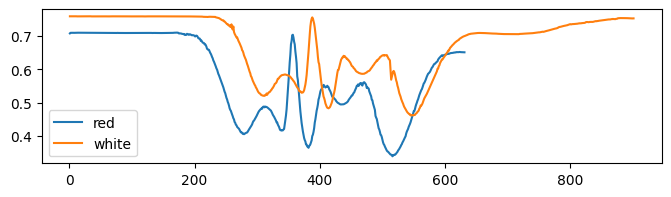

In [5]:
if GRAPH_SHOW:
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(club1['frame'], club1['HOSEL_y'], label='red')
    ax.plot(club2['frame'], club2['HOSEL_y'], label='white')
    ax.legend()
    plt.show()

In [6]:
delay_frame = ta.calculate_delay_frame(club1, club2, 'HOSEL')
print(f'delay_frame: {delay_frame}')

delay_frame: -32


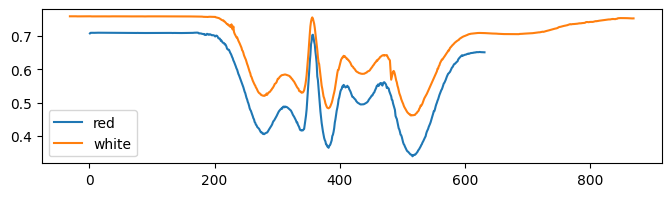

In [7]:
if GRAPH_SHOW:
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(club1['frame'], club1['HOSEL_y'], label='red')
    ax.plot(club2['frame'] + delay_frame, club2['HOSEL_y'], label='white')
    ax.legend()
    plt.show()

In [8]:
img_num = 50

img1 = cv2.imread(f'C:/Users/kitano/3d_reconstruction/data/img/red_0712_0016/red_0712_0016_{img_num}.jpg')
img2 = cv2.imread(f'C:/Users/kitano/3d_reconstruction/data/img/white_0712_0016/white_0712_0016_{img_num - delay_frame}.jpg')

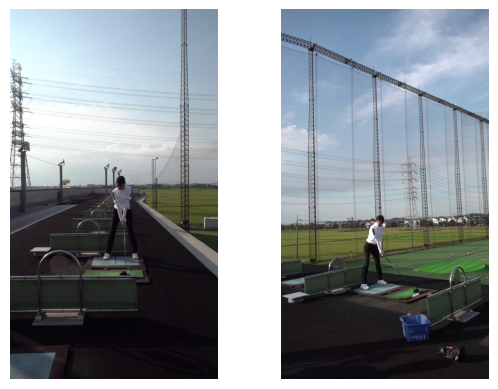

In [9]:
if GRAPH_SHOW:
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

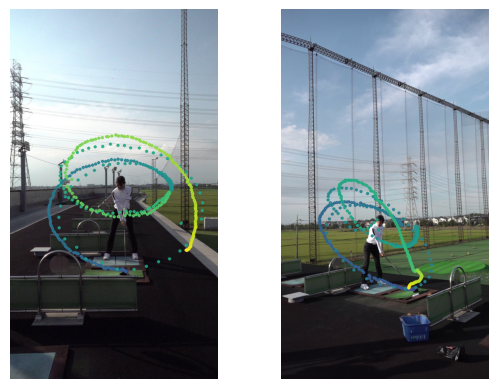

In [10]:
if GRAPH_SHOW:
    rgb_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    rgb_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    cmap = plt.get_cmap('viridis')

    height, width, _ = img1.shape

    min_frame = club1['frame'].min()
    max_frame = club1['frame'].max()
    for x, y, i in zip(club1['HOSEL_x'], club1['HOSEL_y'], club1['frame']):
        normalized_value = (i - min_frame) / (max_frame - min_frame)
        color = cmap(normalized_value)[:-1]
        color = tuple([int(c * 255) for c in color])
        cv2.circle(rgb_img1, (int(x*width), int(y*height)), 5, color, 5)

    min_frame = club2['frame'].min()
    max_frame = club2['frame'].max()
    for x, y, i in zip(club2['HOSEL_x'], club2['HOSEL_y'], club2['frame']):
        normalized_value = (i - min_frame) / (max_frame - min_frame)
        color = cmap(normalized_value)[:-1]
        color = tuple([int(c * 255) for c in color])
        cv2.circle(rgb_img2, (int(x*width), int(y*height)), 5, color, 5)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(rgb_img1)
    ax[1].imshow(rgb_img2)
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

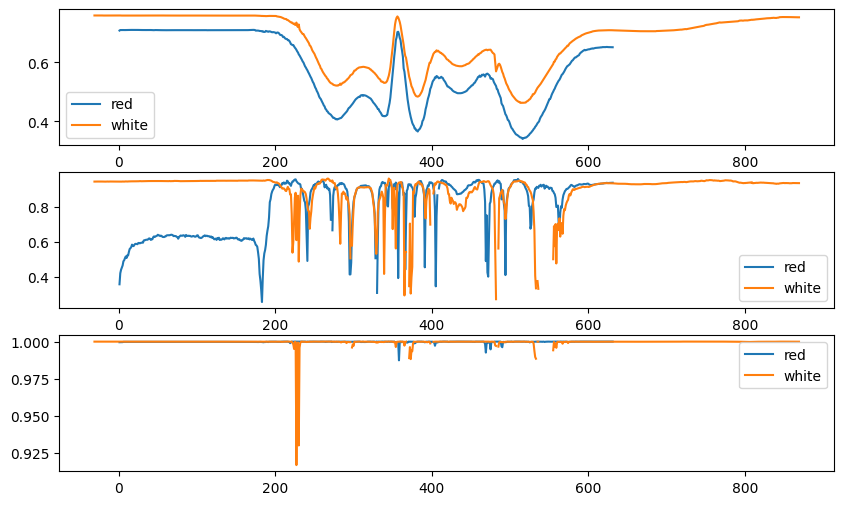

In [11]:
if GRAPH_SHOW:
    fig, ax = plt.subplots(3, 1, figsize=(10, 6))

    ax[0].plot(club1['frame'], club1['HOSEL_y'], label='red')
    ax[0].plot(club2['frame'] + delay_frame, club2['HOSEL_y'], label='white')
    ax[0].legend()

    ax[1].plot(conf1['frame'], conf1['BOX_conf'], label='red')
    ax[1].plot(conf2['frame'] + delay_frame, conf2['BOX_conf'], label='white')
    ax[1].legend()

    ax[2].plot(conf1['frame'], conf1['HOSEL_conf'], label='red')
    ax[2].plot(conf2['frame'] + delay_frame, conf2['HOSEL_conf'], label='white')
    ax[2].legend()

    plt.show()

In [12]:
thr = 0.85

new_club1 = club1.copy()
new_club2 = club2.copy()

new_club1.loc[conf1['BOX_conf'] <= thr, 'HOSEL_x'] = None
new_club1.loc[conf1['BOX_conf'] <= thr, 'HOSEL_y'] = None
new_club1.loc[conf1['BOX_conf'] <= thr, 'GRIP_x'] = None
new_club1.loc[conf1['BOX_conf'] <= thr, 'GRIP_y'] = None
new_club1.loc[conf1['BOX_conf'] <= thr, 'TOE_x'] = None
new_club1.loc[conf1['BOX_conf'] <= thr, 'TOE_y'] = None

new_club2.loc[conf2['BOX_conf'] <= thr, 'HOSEL_x'] = None
new_club2.loc[conf2['BOX_conf'] <= thr, 'HOSEL_y'] = None
new_club2.loc[conf2['BOX_conf'] <= thr, 'GRIP_x'] = None
new_club2.loc[conf2['BOX_conf'] <= thr, 'GRIP_y'] = None
new_club2.loc[conf2['BOX_conf'] <= thr, 'TOE_x'] = None
new_club2.loc[conf2['BOX_conf'] <= thr, 'TOE_y'] = None

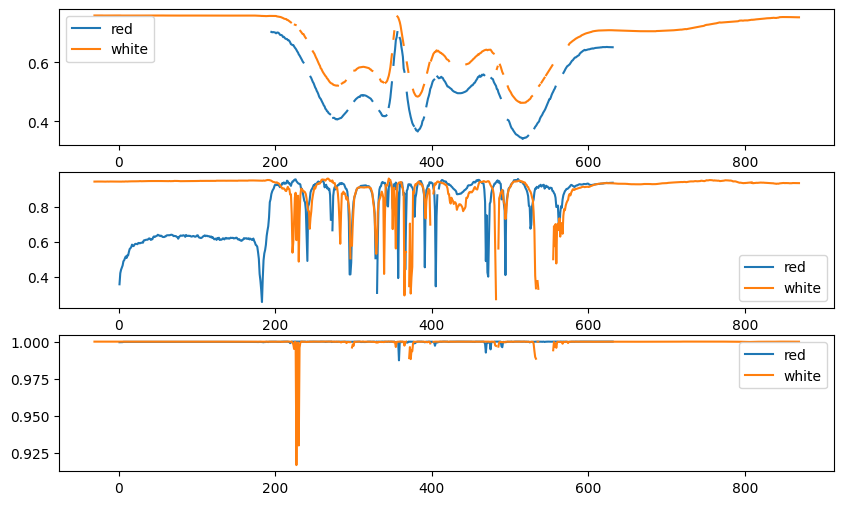

In [13]:
if GRAPH_SHOW:
    fig, ax = plt.subplots(3, 1, figsize=(10, 6))

    ax[0].plot(new_club1['frame'], new_club1['HOSEL_y'], label='red')
    ax[0].plot(new_club2['frame'] + delay_frame, new_club2['HOSEL_y'], label='white')
    ax[0].legend()

    ax[1].plot(conf1['frame'], conf1['BOX_conf'], label='red')
    ax[1].plot(conf2['frame'] + delay_frame, conf2['BOX_conf'], label='white')
    ax[1].legend()

    ax[2].plot(conf1['frame'], conf1['HOSEL_conf'], label='red')
    ax[2].plot(conf2['frame'] + delay_frame, conf2['HOSEL_conf'], label='white')
    ax[2].legend()

    plt.show()

In [31]:
not_null_index1 = set(new_club1[new_club1['HOSEL_x'].notnull()].index)
not_null_index2 = set(new_club2[new_club2['HOSEL_x'].notnull()].index - delay_frame)

common_index = np.array(sorted(list(not_null_index1 & not_null_index2)))
print(f'common index length: {len(common_index)}')

common index length: 276


In [54]:
sync_club1 = new_club1.iloc[common_index].copy()
sync_club2 = new_club2.iloc[common_index - delay_frame].copy()

height, width, _ = img1.shape

for c in sync_club1.columns[1::2]:
    sync_club1[c] = sync_club1[c] * width
    sync_club2[c] = sync_club2[c] * width
for c in sync_club1.columns[2::2]:
    sync_club1[c] = sync_club1[c] * height
    sync_club2[c] = sync_club2[c] * height

In [57]:
# sync_club1.to_csv('C:/Users/kitano/3d_reconstruction/data/sample/club1_position_data.csv', index=False, header=True)
# sync_club2.to_csv('C:/Users/kitano/3d_reconstruction/data/sample/club2_position_data.csv', index=False, header=True)

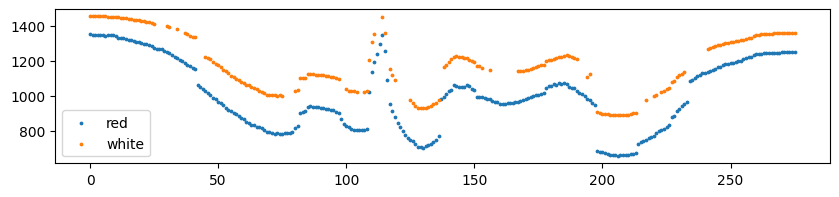

In [56]:
if GRAPH_SHOW:
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.scatter([i for i in range(len(sync_club1))], sync_club1['HOSEL_y'], s=3, label='red')
    ax.scatter([i for i in range(len(sync_club2))], sync_club2['HOSEL_y'], s=3, label='white')
    ax.legend()
    plt.show()

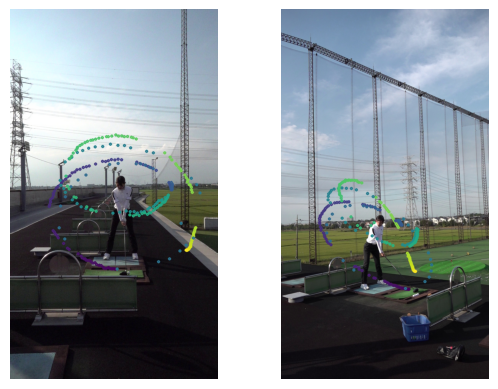

In [17]:
if GRAPH_SHOW:
    rgb_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    rgb_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    cmap = plt.get_cmap('viridis')

    height, width, _ = img1.shape

    min_frame = sync_club1['frame'].min()
    max_frame = sync_club1['frame'].max()
    for x, y, i in zip(sync_club1['HOSEL_x'], sync_club1['HOSEL_y'], sync_club1['frame']):
        normalized_value = (i - min_frame) / (max_frame - min_frame)
        color = cmap(normalized_value)[:-1]
        color = tuple([int(c * 255) for c in color])
        cv2.circle(rgb_img1, (int(x*width), int(y*height)), 5, color, 5)

    min_frame = sync_club2['frame'].min()
    max_frame = sync_club2['frame'].max()
    for x, y, i in zip(sync_club2['HOSEL_x'], sync_club2['HOSEL_y'], sync_club2['frame']):
        normalized_value = (i - min_frame) / (max_frame - min_frame)
        color = cmap(normalized_value)[:-1]
        color = tuple([int(c * 255) for c in color])
        cv2.circle(rgb_img2, (int(x*width), int(y*height)), 5, color, 5)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(rgb_img1)
    ax[1].imshow(rgb_img2)
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

In [18]:
pts1 = np.float32(sync_club1[['HOSEL_x', 'HOSEL_y']].values)
pts2 = np.float32(sync_club2[['HOSEL_x', 'HOSEL_y']].values)

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)
K = np.array(KNOWN_CALIBRATION_DATA['FDR-AX700']['mtx'])
E = K.T.dot(F).dot(K)

U, S, Vt = np.linalg.svd(E)
W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
R = U.dot(W).dot(Vt)
T = U[:, 2]

In [19]:
print(f'Rotation: {R}')
print(f'Translation: {T}')

Rotation: [[ 0.37501608  0.19041952  0.90725043]
 [ 0.18796941 -0.97396535  0.12672406]
 [ 0.90776123  0.12301177 -0.40104571]]
Translation: [-0.49696761 -0.28695847  0.81894935]


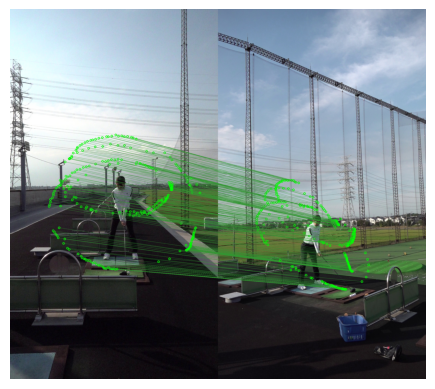

In [20]:
draw_feature_matches(img1, img2, pts1, pts2)

In [21]:
reconstructed_3d = reconstruct_3D(pts1, pts2, K, R, T)
visualize_3d_points(reconstructed_3d)